In [255]:
#fit a regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
from xgboost import plot_importance

from xgboost import plot_tree



In [256]:
df = pd.read_excel(r"E:\Documentos\02_Programming\A-data-driven-approach-to-marking-of-plastic-materials-by-laser-micro-machining\Image processing\Contrast and Histograms\Real DOE\DOE UV results.xlsx")  # Adjust the path to your dataset

df.head()

,Pattern,Line width,Laser power,Speed,Pulse Frequency,LDPE black,LDPE white,PP black,PP white,TPE black,TPE white
0,1111,0.04,60,200,10,56.627273,27.336801,44.499813,35.926909,32.644855,41.098969
1,1112,0.04,60,200,30,64.600129,20.344014,58.333990,24.256039,33.982882,25.686821
2,1113,0.04,60,200,50,64.994618,20.626245,62.825093,23.773932,35.027344,25.084578
3,1121,0.04,60,800,10,30.417156,39.979949,41.913434,44.364976,22.701022,43.749489
4,1122,0.04,60,800,30,19.799084,33.545615,23.858571,44.364170,18.754696,30.658517


In [257]:
# Selecting input features and the target variable
X = df[['Line width','Laser power', 'Speed', 'Pulse Frequency']].to_numpy()
y = df['LDPE black'].to_numpy() # Assuming you're optimizing for 'LDPE black'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=22)

In [258]:
xgb = XGBRegressor(verbosity=0)

In [259]:
cv_params = {
    'n_estimators': [30,40,50,60,70,80,90,100,110,120],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0,3],
    'max_depth': [3, 4, 5,6,7,8,9,10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

In [260]:
xgb_cv = GridSearchCV(xgb,
                      cv_params,
                      scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],  # Appropriate for regression
                      cv=5,
                      refit='r2'  # You might refit based on the R-squared value or any other preferred metric
                     )



In [261]:
%%time
# fit the GridSearch model to training data

### YOUR CODE HERE

xgb_cv = xgb_cv.fit(X_train, y_train)
xgb_cv

CPU times: total: 2h 4min 47s
Wall time: 17min 16s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0, 3],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [30, 40, 50, 60, 70, 80, 90, 100, 110,
                                          120],
                         'subsample': [0.8, 0.9, 1.0]},
             refit='r2',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'])

In [262]:
# Predicting on the training set using the best estimator found by GridSearchCV
y_pred_train = xgb_cv.best_estimator_.predict(X_train)

# Calculating R-squared, MSE, and MAE for the training set
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Printing the metrics for the training set
print(f"Training Data Metrics:")
print(f"R-squared: {r2_train}")
print(f"Mean Squared Error: {mse_train}")
print(f"Mean Absolute Error: {mae_train}")

Training Data Metrics:
R-squared: 0.9631335517571983
Mean Squared Error: 12.274101297832472
Mean Absolute Error: 2.6724393516726943


In [263]:
# Apply your model to predict on your test data. Call this output "y_pred".

### YOUR CODE HERE ###

y_pred = xgb_cv.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

Mean Absolute Error: 4.468990945673014
Mean Squared Error: 41.975576468827164
Root Mean Squared Error: 6.478856108050801
R^2 Score: 0.8633747357203249


In [264]:
# Assuming xgb_cv is your GridSearchCV object
best_params = xgb_cv.best_params_

# Option 1: Use the best estimator directly
best_model = xgb_cv.best_estimator_

#print
print(best_params)
print(best_model)

{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.9}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

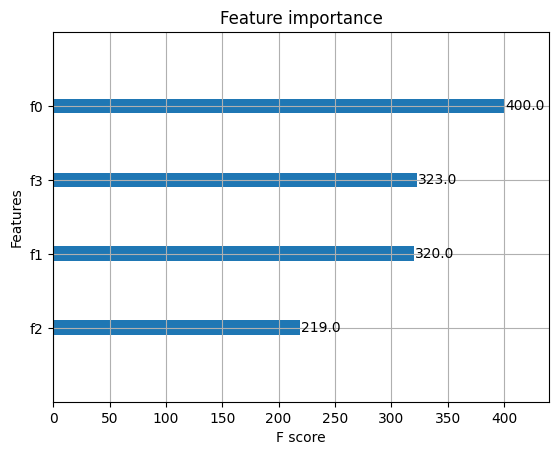

In [265]:
# Plot the relative feature importance of the predictor variables in your model.

### YOUR CODE HERE ###

plot_importance(xgb_cv.best_estimator_)

In [266]:
#import pickle

# Save the model to disk
#filename = 'xgb_cv_LDPE_black_r2_09.sav'
#pickle.dump(best_model, open(filename, 'wb'))

In [267]:
# Example of loading the model back
#loaded_model = pickle.load(open(filename, 'rb'))

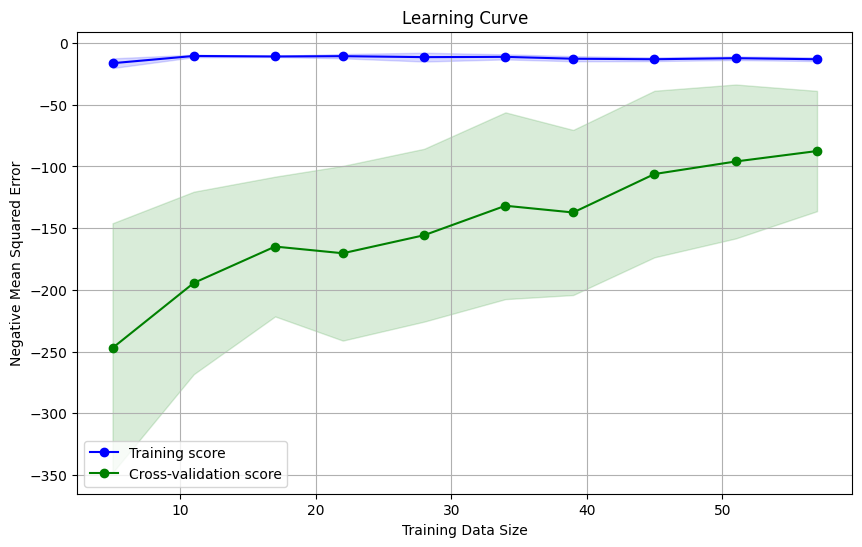

In [268]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Define your model - using the best estimator found by GridSearchCV
model = xgb_cv.best_estimator_

# Define the training data and target variable
X, y = X_train, y_train  # Using the entire dataset for learning curve can give a more comprehensive view

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, 
                                                        scoring='neg_mean_squared_error',
                                                        n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set (validation) scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 6))

plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.15)

plt.plot(train_sizes, test_mean, label='Cross-validation score', color='green', marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.15)

plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Negative Mean Squared Error')
plt.legend(loc='best')
plt.grid()

plt.show()